# Sparkify Project - Cluster

In [1]:
# install pandas, matplotlib, and scikit-learn
sc.install_pypi_package("pandas==1.0.1") 
sc.install_pypi_package("matplotlib", "https://pypi.org/simple") 
sc.install_pypi_package("scikit-learn")

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1594069837171_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window
import datetime

from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoderEstimator, MinMaxScaler, VectorAssembler)
from pyspark.ml.classification import (
    DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LogisticRegression)
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Load and Clean Dataset

In [4]:
# Read in full sparkify dataset
event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
df = spark.read.json(event_data)
df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042')

In [5]:
# Check Schema
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

In [6]:
# Check the number of records
df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

26259199

In [7]:
# Users without registration are not valid for churn analysis, and thus will be dropped.
df_valid = df.dropna(subset=['registration'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# Check number of missing values for each column
missing_values = [F.count(F.when(F.col(c).isNull(), c)).alias(c)
                  for c in df_valid.columns]
df_valid.select(missing_values).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+
| artist|auth|firstName|gender|itemInSession|lastName| length|level|location|method|page|registration|sessionId|   song|status| ts|userAgent|userId|
+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+
|4630448|   0|        0|     0|            0|       0|4630448|    0|       0|     0|   0|           0|        0|4630448|     0|  0|        0|     0|
+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+

`artist`, `length`, and `song` will be null when a user is visiting pages other than `NextSong`.

In [9]:
# Check for the page when the 'artist' is not null
df_valid.filter(F.col('artist').isNotNull()).select(
    'page').dropDuplicates().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+
|    page|
+--------+
|NextSong|
+--------+

In [10]:
# Number of users
num_users = df_valid.select("userId").dropDuplicates().count()
print(num_users)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

22277

# Feature Engineering
Clean data, define user churn and create aggregate features. Prepare stages such as indexing and one-hot encoding categorical features, and transforming feature columns into a single column for ML pipeline.

In [31]:
def clean_data(df):
    """Return valid data by dropping missing values in registration and imputing length."""
    df_clean = df.dropna(subset=['registration']).na.fill(
        0, subset=['length'])

    return df_clean


def is_churn(df):
    """Return dataframe with labels for churn users."""

    flag_churn_event = F.udf(
        lambda x: 1 if x == 'Cancellation Confirmation' else 0, T.IntegerType())

    df_new = df.withColumn(
        'churn_event', flag_churn_event(F.col('page')))

    df_new = df_new.withColumn('label', F.max(
        'churn_event').over(Window.partitionBy('userId')))

    return df_new


def avg_itemInSession(df):
    """ Return datafram with average itemInSession. """

    df_new = df.withColumn('avg_itemInSession', F.avg(
        'itemInSession').over(Window.partitionBy('userId')))

    return df_new


def registration_days(df):
    """Return the maximum number of days since registration."""

    df_new = df.withColumn('registration date', (F.col(
        'registration')/1000).cast(T.TimestampType()))

    df_new = df_new.withColumn(
        'date', (F.col('ts')/1000).cast(T.TimestampType()))

    df_new = df_new.withColumn('days_since_registration', F.max(F.datediff(
        'date', 'registration date')).over(Window.partitionBy('userId'))).drop('registration date', 'date')

    return df_new


def timestamp(df):
    """Return dataframe with hour, day, and month."""

    get_hour = F.udf(lambda x: datetime.datetime.fromtimestamp(
        x / 1000.0).hour, T.IntegerType())
    get_day = F.udf(lambda x: datetime.datetime.fromtimestamp(
        x / 1000.0).day, T.IntegerType())
    get_month = F.udf(lambda x: datetime.datetime.fromtimestamp(
        x / 1000.0).month, T.IntegerType())

    df_new = df.withColumn('hour', F.avg(get_hour(F.col('ts'))).over(Window.partitionBy('userId')))\
        .withColumn('day', F.avg(get_day(F.col('ts'))).over(Window.partitionBy('userId')))\
        .withColumn('month', F.avg(get_month(F.col('ts'))).over(Window.partitionBy('userId')))

    return df_new


# create aggregate features from the column 'page'
pages = ['Thumbs Down', 'Roll Advert', 'Add Friend', 'Error']


def aggregate_features(df):
    """Return selected aggregate features from page."""
    df_new = df

    for page in pages:

        flag_page = F.udf(lambda x: 1 if x ==
                          page else 0, T.IntegerType())
        df_new = df_new.withColumn('flag', flag_page('page'))
        df_new = df_new.withColumn(
            'num_' + page, F.sum('flag').over(Window.partitionBy('userId'))).drop('flag')

    return df_new


def level_phase(df):
    """ Return dataframe with phases of users' subscription level."""

    df_new = df
    flag_downgrade_event = F.udf(
        lambda x: 1 if x == "Submit Downgrade" else 0, T.IntegerType())
    df_new = df_new.withColumn(
        "downgraded", flag_downgrade_event("page"))

    windowval = Window.partitionBy("userId").orderBy(
        F.desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
    df_new = df_new.withColumn(
        "phase", F.sum("downgraded").over(windowval))

    return df_new


def retrive_state(df):
    """Return dataframe with uesrs' last states retrived from locations."""
    df_new = df
    get_state = F.udf(lambda x: x[-2:])
    df_new = df_new.withColumn("state", get_state(df_new['location']))

    return df_new


ignore_list = ['artist',
               'auth',
               'firstName',
               'length',
               'lastName',
               'method',
               'page',
               'registration',
               'sessionId',
               'song',
               'ts',
               'userAgent',
               'churn_event',
               'itemInSession'
               ]


def ignore(df, ignore_list):
    """Remove unnecessary feature columns."""
    df_new = df.drop(*ignore_list)

    return df_new


def preprocess_data(df):
    """
      1. Remove invalid data.
      2. Add churn event and churn user labels.
      3. Add average items in session.
      4. Add number of days since registration.
      5. Add hour, day, and month.
      6. Add phase of scription level.
      7. Add aggregate features.
      8. Get state from location.
      9. Remove unnecessary feature columns.
    """

    df_clean = clean_data(df)
    df_churn = is_churn(df_clean)
    df_item = avg_itemInSession(df_churn)
    df_reg_days = registration_days(df_item)
    df_timestamp = timestamp(df_reg_days)
    df_level_phase = level_phase(df_timestamp)
    df_aggregate = aggregate_features(df_level_phase)
    df_state = retrive_state(df_aggregate)
    df_processed = ignore(df_state, ignore_list)

    return df_processed


df_processed = preprocess_data(df).dropDuplicates().cache()
df.unpersist()


# Prepare stages for ML Pipeline
stages = []

# Index and one-hot encode categorical columns
cat_columns = ['gender', 'status', 'state', 'phase']

for column in cat_columns:
    indexer = StringIndexer(inputCol=column, outputCol=column+'_index')
    encoder = OneHotEncoderEstimator(
        inputCols=[indexer.getOutputCol()], outputCols=[column + '_vect'])

    stages += [indexer, encoder]

num_columns = [
    'avg_itemInSession',
    'days_since_registration',
    'hour',
    'day',
    'month',
    'num_Thumbs Down',
    'num_Roll Advert',
    'num_Add Friend',
    'num_Error'
]

# Transform columns into a single vector column.
vect_assembler_inputs = [c + '_vect' for c in cat_columns] + num_columns
assembler = VectorAssembler(
    inputCols=vect_assembler_inputs, outputCol="features")

stages += [assembler]

# Rescale  each feature into the range from 0 to 1.
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

stages += [scaler]


# Instantiate classifiers
lr = LogisticRegression(labelCol='label', featuresCol='scaled_features')

rfc = RandomForestClassifier(
    labelCol='label', featuresCol='scaled_features')

gbt = GBTClassifier(labelCol='label', featuresCol='scaled_features',
                    maxDepth=7, maxIter=50, stepSize=0.8, subsamplingRate=0.8)

# Set stages for classifiers
stages_lr = stages + [lr]
stages_rfc = stages + [rfc]
stages_gbt = stages + [gbt]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
df_processed.groupBy('label').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----+
|label|count|
+-----+-----+
|    1|24980|
|    0|83183|
+-----+-----+

# Modeling
Three different models are trained and evaluated with full dataset which is split into 80% training data and 20% testing data. ML pipelines with stages as described in the feature engineering section are fitted and transformed. Three different models are trained and evaluated with F1 scores and AUC scores. The classifiers for the models are Logistic Regression, Random Forest Classifier, and Gradient Boosted Tree Classifier. 

In [32]:
# Split the full dataset into train and test sets.
train, test = df_processed.randomSplit([0.8, 0.2], seed=42)
train.cache()
test.cache()
df_processed.unpersist()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[gender: string, level: string, location: string, status: bigint, userId: string, label: int, avg_itemInSession: double, days_since_registration: int, hour: double, day: double, month: double, downgraded: int, phase: bigint, num_Thumbs Down: bigint, num_Roll Advert: bigint, num_Add Friend: bigint, num_Error: bigint, state: string]

In [33]:
# Set the stages for ML Pipeline
pipeline_lr = Pipeline().setStages(stages_lr)
pipeline_rfc = Pipeline().setStages(stages_rfc)
pipeline_gbt = Pipeline().setStages(stages_gbt)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
model_lr = pipeline_lr.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
model_rfc = pipeline_rfc.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
model_gbt = pipeline_gbt.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-34:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 5895



# Model Evaluations

In [18]:
# Instantiate evaluators

# F1 score evaluator
f1_eval = MulticlassClassificationEvaluator(
    labelCol='label', metricName='f1')

# areaUnderROC AUC evaluator
AUC_eval = BinaryClassificationEvaluator(
    labelCol='label', metricName="areaUnderROC")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
def evaluate_model(model):
    """ Return f1 and AUC scores of the model evaluated with test data."""
    preds = model.transform(test)
    f1 = f1_eval.evaluate(preds)
    AUC = AUC_eval.evaluate(preds)
    
    return f1, AUC

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Logistic Regression

In [20]:
lr_f1, lr_AUC = evaluate_model(model_lr)
print('Logistic Regression')
print('F1 =', lr_f1)
print('AUC =', lr_AUC)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression
F1 = 0.8480287037872147
AUC = 0.8702475368653163

### Random forest classifier

In [21]:
rfc_f1, rfc_AUC = evaluate_model(model_rfc)
print('Random Forest Classifier')
print('F1 =', rfc_f1)
print('AUC =', rfc_AUC)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-20:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 5536



Random Forest Classifier
F1 = 0.8470261687401073
AUC = 0.8603725532686143

### Gradient-boosted tree classifier

In [35]:
gbt_f1, gbt_AUC = evaluate_model(model_gbt)
print('Gradient-boosted Tree Classifier')
print('F1 =', gbt_f1)
print('AUC =', gbt_AUC)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Gradient-boosted Tree Classifier
F1 = 0.9707250705240945
AUC = 0.9845772981652774

Exception in thread cell_monitor-35:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 11786



In [36]:
preds = model_gbt.transform(test).select(
    'label', 'probability', 'prediction').toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
labels = preds['label']
predictions = preds['prediction']
probabilities = preds['probability'].apply(lambda x: x[1]).values

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
print(classification_report(labels, predictions))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     16603
           1       0.97      0.90      0.93      4951

    accuracy                           0.97     21554
   macro avg       0.97      0.95      0.96     21554
weighted avg       0.97      0.97      0.97     21554

In [39]:
confusion_matrix(labels, predictions)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([[16484,   119],
       [  503,  4448]])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

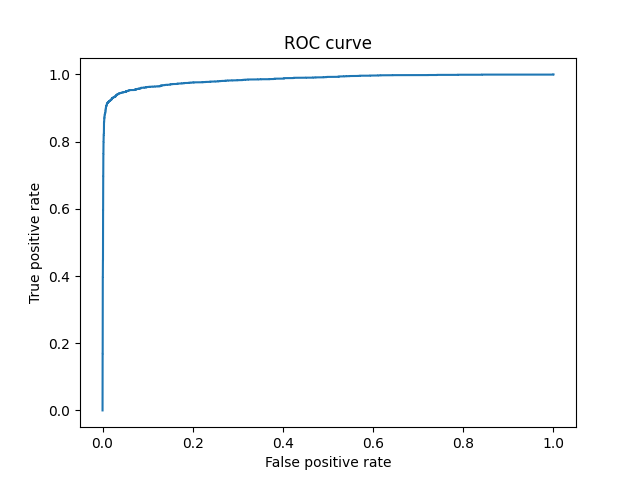

In [40]:
# Create ROC curve
fpr, tpr, _ = roc_curve(labels, probabilities)

plt.clf()

plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

%matplot plt